In [1]:
# Imports
from pyomo.environ import *
from pyomo.opt import *
from pyomo.core import * 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

In [2]:
# set the parameter
n = 10  # number of locations

min_x = 0
min_y = 0
max_x = 100
max_y = 100

In [3]:
# Euclidian distance function given two vectors
def euc_dist(v1, v2):
    return round(np.linalg.norm(v1 - v2), 7)

# Generate dictionary of distances for a given array (starting index from 1)
def generate_dist_dict(arr):
    dist_dict = {}
    for i in range(n):
        for j in range(n):
            dist_dict[(i+1, j+1)] = euc_dist(arr[i], arr[j])
    return dist_dict

# generate n locations and calculate distances between them
locations = np.random.randint([min_x, min_y], [max_x, max_y], (n, 2))
distance = generate_dist_dict(locations)

In [4]:
# Objective rule: Minimize total distance
def objective_rule(model):
    
    return sum(model.SELECT[i, j] * model.distance[i, j] for i in model.i for j in model.i)

In [5]:
def one_successor_rule(model, i):
    
    # Must have an exact one successor
    return sum(model.SELECT[i, j] for j in model.i if j != i) == 1

def one_predecessor_rule(model, j):
    
    # Must have an exact one predecessor
    return sum(model.SELECT[i, j] for i in model.i if i != j) == 1

def subset_rule(model, subset_index):
    subset = subset_constraints[subset_index]
    return sum(model.SELECT[i, j] for i in subset for j in subset if i != j) <= (len(subset) - 1)

In [6]:
def pyomo_create_model():
    # Create concrete model
    model = ConcreteModel()

    # Define set of index
    model.i = Set(initialize=[i for i in range(1, n+1)], ordered = True)
    model.subset_index = Set(ordered = True)

    # Define decision variable (n x n)
    model.SELECT = Var((model.i * model.i), domain=Binary, initialize = 0)

    # Define parameters
    model.distance = Param((model.i * model.i), initialize = distance)

    # Objective function
    model.objective = Objective(rule = objective_rule, sense = minimize)

    # Constraints
    model.successorConstraint = Constraint(model.i, rule=one_successor_rule)
    model.predecessorConstraint = Constraint(model.i, rule=one_predecessor_rule)
    model.subsetConstraint = Constraint(model.subset_index, rule=subset_rule)
    
    return model

In [7]:
def get_list_cycle(model):
    '''
    Function to get all cycles in our model
    '''
    # Initialize necessary variables
    visited = []
    cycle_list = []
    
    while len(visited) < n:
        
        # find which city that hasn't been visited
        idx = [i for i in model.i.ordered_data() if i not in visited][0]
        
        cycle = get_cycle_starting_from_idx(model, idx) # function defined below
        
        # add the subset to cycle_list
        cycle_list.append(cycle)
        
        # add each visited cities to visited array
        visited += cycle
        
    return cycle_list

In [8]:
def get_cycle_starting_from_idx(model, idx):
    
    '''
    Function to get cycle from a given city
    '''
    subset = set()
    
    # starting city
    subset.add(idx)
    i = idx
    
    # find where i goes to
    for j in model.i.ordered_data():
        if model.SELECT[i, j].value == 1:
            subset.add(j)
            break

    # While we're not back to the starting city
    while j != idx:
        
        # Go to the next city and add it to the cycle
        i = j
        for j in model.i.ordered_data():
            if model.SELECT[i, j].value == 1:
                subset.add(j)
                break
    return list(subset)  # list of visited cities

In [9]:
def results_to_df(model, n):
    '''
    Function to convert optimal solution to data frame
    '''
    df = np.zeros((n, n))
    for i in model.i.ordered_data():
        for j in model.i.ordered_data():
            df[i-1, j-1] = model.SELECT[i, j].value
    df = pd.DataFrame(df).astype('int32')
    df.columns = model.i.ordered_data()
    df.index = model.i.ordered_data()
    return df

In [10]:
# Create model
model = pyomo_create_model()

# Initialize subset constraints
subset_constraints = []

# Initialize solver
opt = SolverFactory("glpk")

# Solve the model
iteration = 1
print(f"Solving model at iteration {iteration}...", end="\r")
results = opt.solve(model)

# Get the cycle that includes 1
cycle = get_list_cycle(model)

locations_df = pd.DataFrame(locations, columns=["x", "y"])

fig, ax = plt.subplots(1, 1, figsize = (10, 7))
ax = sns.scatterplot(locations_df["x"], locations_df["y"], s = 100)

# add arcs
for i in model.i:
    for j in model.i:
        if model.SELECT[i, j].value == 1:
            x_line = [locations_df.iloc[i-1,0], locations_df.iloc[j-1,0]]
            y_line = [locations_df.iloc[i-1,1], locations_df.iloc[j-1,1]]
            ax.plot(x_line, y_line, color = "red", linewidth=2)
fig.savefig(f"iteration_{iteration}.jpg", dpi=100)
fig.clear()

# Subtour elimination if necessary
while len(cycle) != 1:
    
    # Increment the iteration number
    iteration += 1
    
    # Add the subset to the constraints and redefine constraint
    subset_constraints += cycle
    for i in cycle:
        if model.subset_index.ordered_data().count(0) == 0:
            model.subset_index.add(0)
        else:
            model.subset_index.add(model.subset_index.ordered_data()[-1] + 1)
    model.subsetConstraint.clear()
    model.subsetConstraint._constructed = False
    model.subsetConstraint.construct()
    
    # Re solve the model
    print(f"Solving model at iteration {iteration}... subset length: {len(subset_constraints)}", end="\r")
    results = opt.solve(model)

    fig, ax = plt.subplots(1, 1, figsize = (10, 7))
    ax = sns.scatterplot(locations_df["x"], locations_df["y"], s = 100)

    # add arcs
    for i in model.i:
        for j in model.i:
            if model.SELECT[i, j].value == 1:
                x_line = [locations_df.iloc[i-1,0], locations_df.iloc[j-1,0]]
                y_line = [locations_df.iloc[i-1,1], locations_df.iloc[j-1,1]]
                ax.plot(x_line, y_line, color = "red", linewidth=2)
    fig.savefig(f"iteration_{iteration}.jpg", dpi=100)
    fig.clear()
        
    # Re evaluate cycle
    cycle = get_list_cycle(model)

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

Number of restricted subset: 5 subsets


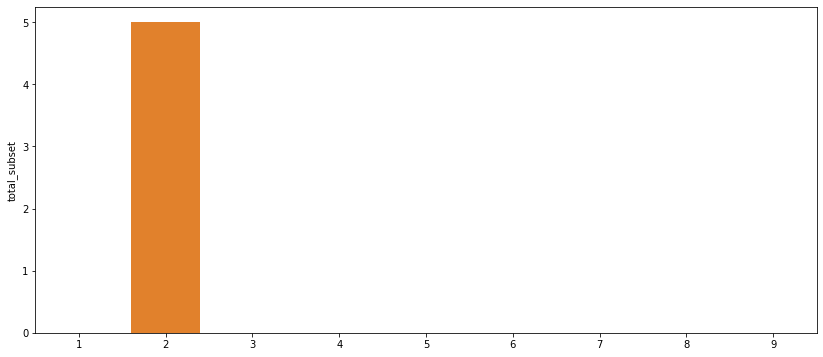

In [11]:
subset_length = list(range(1, n))
total_subset = []
print(f"Number of restricted subset: {len(subset_constraints)} subsets")
for i in range(1, n):
    total_subset.append(len([subset for subset in subset_constraints if len(subset) == i]))
data = pd.DataFrame({"total_subset":total_subset}, index=subset_length)
fig, ax = plt.subplots(1, 1, figsize = (14, 6))
ax = sns.barplot(data.index, data["total_subset"])

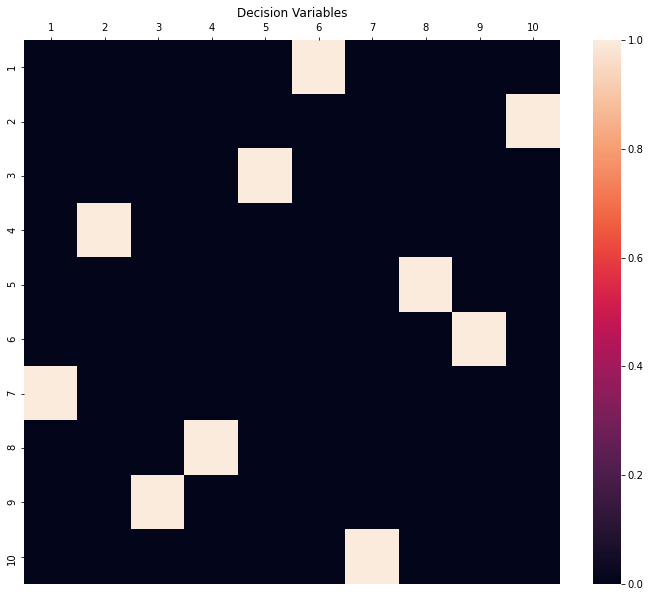

In [12]:
df = results_to_df(model, n)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax = sns.heatmap(df)
ax.xaxis.set_ticks_position('top')
_ = ax.set_title("Decision Variables")

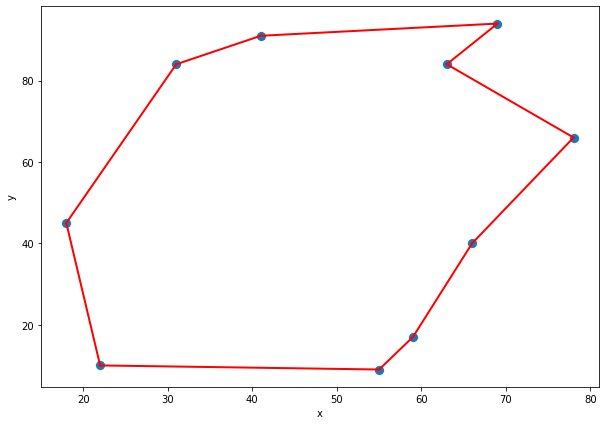

In [13]:
locations_df = pd.DataFrame(locations, columns=["x", "y"])

fig, ax = plt.subplots(1, 1, figsize = (10, 7))
ax = sns.scatterplot(locations_df["x"], locations_df["y"], s = 100)

# add arcs
for i in model.i:
    for j in model.i:
        if model.SELECT[i, j].value == 1:
            x_line = [locations_df.iloc[i-1,0], locations_df.iloc[j-1,0]]
            y_line = [locations_df.iloc[i-1,1], locations_df.iloc[j-1,1]]
            ax.plot(x_line, y_line, color = "red", linewidth=2)